# Surface water mass transformation in MOM6

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1, sigma2
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42461/status,
Dashboard: /proxy/42461/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37731,Workers: 7
Dashboard: /proxy/42461/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:46669,Total threads: 4
Dashboard: /proxy/33773/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:33391,


## Load data

In [11]:
# USE THIS CELL IF EXPERIMENT IS ALREADY IN DATABASE
session = cc.database.create_session()
expt = 'panant-005-zstar-ACCESSyr2'
expt_name = 'panan_005deg_jra55_ryf'
year_all = range(1991, 2000)

frequency = '1 monthly'
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'

In [12]:
# if only monthly data and no SST (tos) and SSS (sos) exist
# includes salt flux from sea ice and restoring
def calculate_SWMT(expt, expt_name, session, year, frequency,
                   path_output, lat_range):

    '''
    Computes southern ocean surface water mass transformation rates
    (partitioned into transformation from heat and freshwater) referenced to
    1000 db from monthly ACCESS-OM2 output.
    Suitable for analysis of high-resolution (0.1 degree) output
    (the scattered .load()'s allowed this)

    expt - text string indicating the original name of the experiment
    expt_name - text string providing a shorter or more descriptive
        name of the experiment
    session - a database session created by cc.database.create_session()
    year - int indicating the year
    path_output - text string indicating directory where output databases
        are to be saved
    filename - text string of the name of the saved file
    lat_north - function computes processes between lat = -90 and
        lat = lat_north

    NOTE: assumes SST is potential temperature (°C) and
          SSS is practical salinity (psu)

    required modules:
    xarray as xr
    numpy as np
    cosima_cookbook as cc
    from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
    '''

    # time and latitude range
    start_time = str(year) + '-01-01'
    end_time = str(year) + '-12-31'
    time_slice = slice(start_time, end_time)
    lat_slice = lat_range

    # load variables
    # potential temperature
    SST = cc.querying.getvar(
        expt, 'thetao', session, frequency=frequency,
        start_time=start_time, end_time=end_time,
        chunks={'yh': '200MB', 'xh': '200MB'}).isel(z_l=0)
    # practical salinity
    SSS_PSU =  cc.querying.getvar(
        expt, 'so', session, frequency=frequency,
        start_time=start_time, end_time=end_time,
        chunks={'yh': '200MB', 'xh': '200MB'}).isel(z_l=0)

    net_surface_heating = cc.querying.getvar(
        expt, 'hfds', session, frequency=frequency,
        start_time=start_time, end_time=end_time,
        chunks={'yh': '200MB', 'xh': '200MB'})
    # mass flux of precip - evap + river ((kg of water)/m^2/s )
    pme_river = cc.querying.getvar(
        expt, 'wfo', session, frequency=frequency,
        start_time=start_time, end_time=end_time,
        chunks={'yh': '200MB', 'xh': '200MB'})
    # Net salt flux into ocean at surface (restoring + sea-ice) 
    # ((kg of salt)/m^2/s )
    salt_flux = cc.querying.getvar(
        expt, 'salt_flux', session, frequency=frequency,
        start_time=start_time, end_time=end_time,
        chunks={'yh': '200MB', 'xh': '200MB'})

    # slice for time and latitudinal constraints
    SST = SST.sel(time=time_slice, yh=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yh=lat_slice)
    net_surface_heating = net_surface_heating.sel(time=time_slice, yh=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yh=lat_slice)

    # extract coordinate arrays
    time_monthly = SST.time.values
    yh = SST.yh.values
    xh = SST.xh.values

    months_standard_noleap = np.array(
        [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    days_per_month = xr.DataArray(
        months_standard_noleap,
        coords=[time_monthly], dims=['time'], name='days per month')

    depth = -0.541281 # st_ocean value of the uppermost cell

    # 2D arrays of depths, longitude, latitude and pressure
    depth_2D = xr.DataArray(
        np.full((len(yh), len(xh)), depth),
        dims=['yh', 'xh'], coords={'yh': yh, 'xh': xh})
    xh_2D = np.tile(xh, (len(yh),1))
    yh_2D = np.tile(yh, (len(xh),1)).transpose()

    pressure = p_from_z(depth_2D, yh_2D)

    # convert units to absolute salinity
    SSS = SA_from_SP(SSS_PSU, pressure, xh_2D, yh_2D)

    ## convert to conservative temperature
    SST_Conservative = CT_from_pt(SSS, SST)

    # compute potential density referenced to 1000dbar
    # (or referenced otherwise, depending on your purpose)
    pot_rho = sigma2(SSS, SST_Conservative).compute()

    # Compute salt transformation (no density binning)
    haline_contraction = beta(SSS, SST_Conservative, pressure)
    # Note that the salt flux has units of (kg of salt)/m^2/s, while beta has
    # units of kg / (g of salt), so we need to multiply the salt flux by 1000,
    # the fresh water flux pme_river has units of (kg of water)/m^2/s and needs
    # to be multiplied by SSS to convert to (g of salt)/m^2/s
    # units of salt_transformation is (kg of water)/m^2 but it will later be
    # divided by time and density and be in m/s:
    salt_transformation = (days_per_month * haline_contraction * (
        SSS * pme_river - 1000 * salt_flux)).compute()

    # Compute heat transformation (no density binning)
    thermal_expansion = alpha(SSS, SST_Conservative, pressure)
    heat_transformation =  (
        thermal_expansion*net_surface_heating*days_per_month).compute()

    # Record the time bounds before summing through time 
    # (just to make sure it's consistent with requested years)
    time_bounds =  (
        str(salt_transformation.coords['time.year'][0].values) + '_' +
        str(salt_transformation.coords['time.month'][0].values) + '-' +
        str(salt_transformation.coords['time.year'][-1].values) + '_' +
        str(salt_transformation.coords['time.month'][-1].values))

    # Isopycnal binning in several steps:
    # cycle through isopycnal bins, determine which cells are within the
    # given bin for each time step, find the transformation values for
    # those cells for each time step, sum these through time.
    # -> array of shape (isopyncal bins * lats * lons) where the array
    # associated with a given isopycnal bin is NaN everywhere except where
    # pot_rho_0 was within the bin, there it has a time summed
    # transformation value

    # alter if this density range doesn't capture surface processes in your
    # study region, or if a different density field (not sigma1) is used
    # isopycnal_bins = np.arange(31, 33.5, 0.02)
    isopycnal_bins = np.arange(36, 38, 0.02)

    bin_bottoms = isopycnal_bins[:-1]
    binned_salt_transformation = xr.DataArray(
        np.zeros((len(bin_bottoms), len(yh), len(xh))),
        coords=[bin_bottoms, yh, xh], dims=['isopycnal_bins', 'yh', 'xh'],
        name='salt transformation in isopycnal bins summed over time')
    binned_salt_transformation.chunk({'isopycnal_bins': 1})
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho.where(pot_rho <= isopycnal_bins[i+1]).where(
            pot_rho > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum(dim='time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform
    print('salt_transformation binning done')

    binned_heat_transformation = xr.DataArray(
        np.zeros((len(bin_bottoms), len(yh), len(xh))),
        coords=[bin_bottoms, yh, xh], dims=['isopycnal_bins', 'yh', 'xh'],
        name='heat transformation in isopycnal bins summed over time')
    binned_heat_transformation.chunk({'isopycnal_bins': 1})

    # This for loop is likely the least efficient part of the code.
    # The problem can be vectorised for improved speed
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho.where(pot_rho <= isopycnal_bins[i+1]).where(
            pot_rho > isopycnal_bins[i]) * 0 + 1
        masked_transform = (heat_transformation * bin_mask).sum(dim='time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform
    print('heat_transformation binning done')

    ndays = days_per_month.sum().values
    salt_transformation = binned_salt_transformation/ndays
    c_p = 3992.1
    heat_transformation = binned_heat_transformation/c_p/ndays

    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation/isopycnal_bin_diff[
        :, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation/isopycnal_bin_diff[
        :, np.newaxis, np.newaxis]
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

    # this procedure defines fluxes from lighter to denser classes
    # as negative, I want the opposite
    salt_transformation = salt_transformation *-1
    heat_transformation = heat_transformation *-1

    # Save to file
    salt_transformation = salt_transformation.expand_dims(time=[year])
    heat_transformation = heat_transformation.expand_dims(time=[year])
    ds = xr.Dataset(
        {'binned_salt_transformation': salt_transformation,
         'binned_heat_transformation': heat_transformation,
         'time_bounds': time_bounds})
    ds.coords['isopycnal_bins'] = isopycnal_bin_mid  # isopycnal bin midpoints
    ds.attrs = {'units': 'm/s'}
    comp = dict(chunksizes=(1, len(ds.isopycnal_bins), 230, 720),
                zlib=True, complevel=5, shuffle=True)
    enc = {var: comp for var in ds.data_vars}
    ds.to_netcdf(
        path_output + 'SWMT_sigma2_' + expt_name + '_mean_' + time_bounds + '.nc',
        encoding=enc)
    print('SWMT_' + expt_name + '_mean_' + time_bounds + '.nc' +
          ' saved to ' + path_output)

In [13]:
%%time
year = 2000
calculate_SWMT(expt, expt_name, session, year, frequency, path_output, lat_range=slice(-79, -59))

salt_transformation binning done
heat_transformation binning done
SWMT_panan_005deg_jra55_ryf_mean_2000_1-2000_12.nc saved to /g/data/e14/cs6673/mom6_comparison/data_DSW/
CPU times: user 6min 56s, sys: 4min 51s, total: 11min 47s
Wall time: 12min 10s


### Spatial sum of SWMT in DSW regions

In [14]:
def mask_from_polygon(lon, lat, xh, yh):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xh, yh)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xh.size, yh.size).transpose()
    mask = xr.DataArray(
        mask, dims=['yh', 'xh'], coords={'xh': xh, 'yh': yh})
    return mask

In [15]:
def shelf_mask_isobath(var, contour_depth, resolution, output_mask=False):
    '''
    Masks varibales by the region polewards of a given isobath
    '''
    
    ds_contour = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Antarctic_slope_contours/' +
        'Antarctic_slope_contour_' + str(contour_depth) + 'm_MOM6_' +
        resolution + 'deg.nc')
    
    shelf_mask = ds_contour.contour_masked_above.sel(yh=slice(var.yh[0], var.yh[-1]))
    yh = ds_contour.yh.sel(yh=slice(var.yh[0], var.yh[-1]))
    xh = ds_contour.xh
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask = shelf_mask.where(shelf_mask == 0)+1
    shelf_mask = shelf_mask.where(shelf_mask == 1, 0)
    
    # multiply the variable with the mask
    masked_var = var * shelf_mask
    
    if output_mask == True:
        return masked_var, shelf_mask
    else:
        return masked_var

In [16]:
"""Spatial sum of SWMT in DSW regions"""

contour_depth = 1000
resolution = expt_name.split('_')[1][:-3]

DSW_region = {
'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
'lon': [[-60, -35, -48, -62, -60],
        [48, 73, 74, 48, 48],
        [128-360, 152-360, 152-360, 128-360, 128-360],
        [185-360, 160-360, 164-360, 172-360, 185-360]],
'lat': [[-71, -75, -78, -75, -71],
        [-65, -66.5, -69, -68, -65],
        [-64.5, -66, -69, -67.5, -64.5],
        [-78, -78, -73, -71.5, -78]]}

area = cc.querying.getvar(
    expt=expt, variable='areacello', session=session, frequency='static', n=1)
xh = area.xh
yh = area.yh

for a, area_text in enumerate(DSW_region['name']):
    mask = mask_from_polygon(DSW_region['lon'][a], DSW_region['lat'][a],
                             xh, yh)
    mask = mask.where(mask == True, 0)
    if a == 0:
        mask_DSW = mask.expand_dims(area=[area_text])
    else:
        mask_DSW = xr.concat((mask_DSW, mask.expand_dims(
            area=[area_text])), dim='area')
mask_DSW = mask_DSW.where(mask_DSW != 0)

ds_SWMT = xr.open_mfdataset(
    path_output + 'SWMT_sigma2_' + expt_name + '_mean_' + str(year) +
    '_1-' + str(year) + '_12.nc', chunks='auto')
swmt_heat = ds_SWMT.binned_heat_transformation
swmt_salt = ds_SWMT.binned_salt_transformation

swmt_heat_shelf = shelf_mask_isobath(swmt_heat, contour_depth, resolution)
swmt_salt_shelf = shelf_mask_isobath(swmt_salt, contour_depth, resolution)
area_shelf = shelf_mask_isobath(area, contour_depth, resolution)

area_DSW = (mask_DSW * area_shelf.sel(yh=slice(-79, -59)))
swmt_heat_DSW_regions = (swmt_heat_shelf * area_DSW/1e6).sum(
    ['xh', 'yh']).compute()
swmt_salt_DSW_regions = (swmt_salt_shelf * area_DSW/1e6).sum(
    ['xh', 'yh']).compute()

swmt_heat_DSW_regions.name = 'binned_heat_transformation_in_DSW_region'
ds = swmt_heat_DSW_regions.to_dataset()
ds['binned_salt_transformation_in_DSW_region'] = swmt_salt_DSW_regions
ds.attrs = {'units': 'Sv'}
comp = dict(zlib=True, complevel=5, shuffle=True)
enc = {var: comp for var in ds.data_vars}
ds.to_netcdf(
    path_output + 'SWMT_sigma2_in_DSW_region_' + expt_name + '_' + str(year) +
    '.nc', encoding=enc)

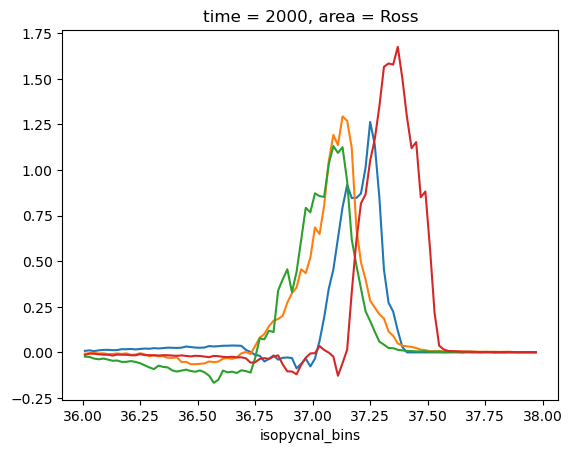

2023-10-20 14:37:55,874 - distributed.nanny - WARNING - Restarting worker
2023-10-20 14:37:55,952 - distributed.nanny - WARNING - Restarting worker
2023-10-20 14:37:56,260 - distributed.nanny - WARNING - Restarting worker
2023-10-20 14:37:57,271 - distributed.nanny - WARNING - Restarting worker


In [17]:
for a in range(4):
    swmt_salt_DSW_regions[0, :, a].plot()

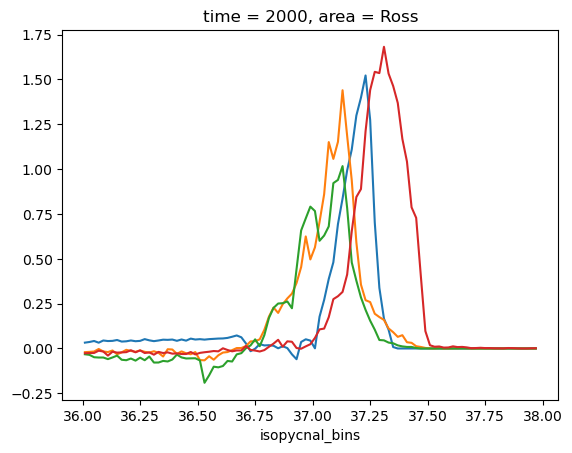

In [10]:
for a in range(4):
    swmt_salt_DSW_regions[0, :, a].plot()

In [6]:
# if daily data of SST (tos) and SSS (sos) exist
# does not include salt flux from sea ice and restoring
def calculate_SWMT(expt, session, year, frequency,
                   path_output, lat_north=-59):

    '''
    Computes southern ocean surface water mass transformation rates
    (partitioned into transformation from heat and freshwater) referenced to
    1000 db from monthly ACCESS-OM2 output.
    Suitable for analysis of high-resolution (0.1 degree) output
    (the scattered .load()'s allowed this)

    expt - text string indicating the name of the experiment
    session - a database session created by cc.database.create_session()
    start_time - text string designating the start date ('YYYY-MM-DD')
    end_time - text string indicating the end date ('YYYY-MM-DD')
    path_output - text string indicating directory where output databases are
        to be saved
    filename - text string of the name of the saved file
    lat_north - function computes processes between lat = -90 and
        lat = lat_north

    NOTE: assumes SST is potential temperature (°C) and
          SSS is practical salinity (psu)

    required modules:
    xarray as xr
    numpy as np
    cosima_cookbook as cc
    from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
    '''

    # load variables
    # potential temperature
    SST = cc.querying.getvar(expt, 'tos', session, frequency='1 daily') 
    # practical salinity
    SSS_PSU =  cc.querying.getvar(expt, 'sos', session, frequency='1 daily')

    net_surface_heating = cc.querying.getvar(
        expt, 'hfds', session, frequency=frequency)
    # mass flux of precip - evap + river ((kg of water)/m^2/s )
    pme_river = cc.querying.getvar(
        expt, 'wfo', session, frequency=frequency)

    # slice for time and latitudinal constraints
    start_time=cftime.datetime(
        year, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)
    end_time=cftime.datetime(
        year, 12, 31, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)
    time_slice = slice(start_time, end_time)
    lat_slice = slice(-90, lat_north)
    SST = SST.sel(time=time_slice, yh=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yh=lat_slice)
    net_surface_heating = net_surface_heating.sel(time=time_slice, yh=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yh=lat_slice)

    # convert to monthly
    time_monthly = pme_river.time.values
    SST = SST.resample(
        time="1M", label='left', loffset=timedelta(days=16)).mean("time")
    SST['time'] = time_monthly
    SSS_PSU = SSS_PSU.resample(
        time="1M", label='left', loffset=timedelta(days=16)).mean("time")
    SSS_PSU['time'] = time_monthly

    # extract coordinate arrays
    yh = SST.yh.values
    xh = SST.xh.values

    months_standard_noleap = np.array(
        [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    days_per_month = xr.DataArray(
        months_standard_noleap,
        coords=[time_monthly], dims=['time'], name='days per month')

    depth = -0.541281 # st_ocean value of the uppermost cell

    # 2D arrays of depths, longitude, latitude and pressure
    depth_2D = xr.DataArray(
        data = np.full((len(yh), len(xh)), depth),
        dims = ["yh","xh"], coords = {'yh': yh, 'xh': xh})
    xh_2D = np.tile(xh,(len(yh),1))
    yh_2D = np.tile(yh,(len(xh),1)).transpose()

    pressure = xr.DataArray(
        p_from_z(depth_2D, yh_2D), coords=[yh, xh], dims=['yh', 'xh'],
        name='pressure', attrs={'units': 'dbar'})
    
    # convert units to absolute salinity
    SSS = xr.DataArray(
        SA_from_SP(SSS_PSU, pressure, xh_2D, yh_2D), coords=[time_monthly, yh, xh],
        dims = ['time', 'yh', 'xh'], name='sea surface salinity',
        attrs={'units': 'Absolute Salinity (g/kg)'})
    ## convert to conservative temperature but in Celsius not Kelvin
    SST_Conservative = xr.DataArray(
        CT_from_pt(SSS, SST), coords=[time_monthly, yh, xh], dims=['time', 'yh', 'xh'],
        name='sea surface temperature', attrs = {'units': 'Conservative Temperature (C)'})
    
    # compute potential density referenced to 1000dbar
    # (or referenced otherwise, depending on your purpose)
    pot_rho = xr.DataArray(
        sigma1(SSS, SST_Conservative), coords=[time_monthly, yh, xh],
        dims = ['time', 'yh', 'xh'], name='potential density ref 1000dbar',
        attrs = {'units': 'kg/m^3 (-1000 kg/m^3)'})
    pot_rho = pot_rho.load()

    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(
        beta(SSS, SST_Conservative, pressure), coords=[time_monthly, yh, xh],
        dims=['time', 'yh', 'xh'],
        name='saline contraction coefficient (constant conservative temp)',
        attrs = {'units': 'kg/g'})
    salt_transformation = haline_contraction*SSS*pme_river*days_per_month
    salt_transformation = salt_transformation.load()

    # Compute heat transformation (no density binning)
    thermal_expansion = xr.DataArray(
        alpha(SSS, SST_Conservative, pressure), coords=[time_monthly, yh, xh],
        dims=['time', 'yh', 'xh'],
        name='thermal expansion coefficient (constant conservative temp)',
        attrs = {'units':'1/K'})
    heat_transformation =  thermal_expansion*net_surface_heating*days_per_month
    heat_transformation = heat_transformation.load()

    # Record the time bounds before summing through time 
    # (just to make sure it's consistent with requested years)
    time_bounds =  (
        str(salt_transformation.coords['time.year'][0].values) + '_' +
        str(salt_transformation.coords['time.month'][0].values) + '-' +
        str(salt_transformation.coords['time.year'][-1].values) + '_' +
        str(salt_transformation.coords['time.month'][-1].values))
    
    # Isopycnal binning in several steps:
    # cycle through isopycnal bins, determine which cells are within the
    # given bin for each time step, find the transformation values for
    # those cells for each time step, sum these through time.
    # -> array of shape (isopyncal bins * lats * lons) where the array
    # associated with a given isopycnal bin is NaN everywhere except where
    # pot_rho_0 was within the bin, there it has a time summed
    # transformation value

    # alter if this density range doesn't capture surface processes in your
    # study region, or if a different density field (not sigma1) is used
    isopycnal_bins = np.arange(31, 33.5, 0.02)
    
    bin_bottoms = isopycnal_bins[:-1]
    binned_salt_transformation = xr.DataArray(
        np.zeros((len(bin_bottoms), len(yh), len(xh))),
        coords=[bin_bottoms, yh, xh], dims=['isopycnal_bins', 'yh', 'xh'],
        name='salt transformation in isopycnal bins summed over time')
    binned_salt_transformation.chunk({'isopycnal_bins': 1})
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho.where(pot_rho <= isopycnal_bins[i+1]).where(
            pot_rho > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum(dim='time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform
    print('salt_transformation binning done')

    binned_heat_transformation = xr.DataArray(
        np.zeros((len(bin_bottoms), len(yh), len(xh))),
        coords=[bin_bottoms, yh, xh], dims=['isopycnal_bins', 'yh', 'xh'],
        name='heat transformation in isopycnal bins summed over time')
    binned_heat_transformation.chunk({'isopycnal_bins': 1})

    # This for loop is likely the least efficient part of the code.
    # The problem can be vectorised for improved speed
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho.where(pot_rho <= isopycnal_bins[i+1]).where(
            pot_rho > isopycnal_bins[i]) * 0 + 1
        masked_transform = (heat_transformation * bin_mask).sum(dim='time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform
    print('heat_transformation binning done')

    ndays = days_per_month.sum().values
    salt_transformation = binned_salt_transformation/ndays
    c_p = 3992.1
    heat_transformation = binned_heat_transformation/c_p/ndays

    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation/isopycnal_bin_diff[
        :, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation/isopycnal_bin_diff[
        :, np.newaxis, np.newaxis]
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

    # this procedure defines fluxes from lighter to denser classes
    # as negative, I want the opposite
    salt_transformation = salt_transformation *-1
    heat_transformation = heat_transformation *-1
    
    # Save to file
    salt_transformation = salt_transformation.expand_dims(time=[year])
    heat_transformation = heat_transformation.expand_dims(time=[year])
    ds = xr.Dataset(
        {'binned_salt_transformation': salt_transformation,
         'binned_heat_transformation': heat_transformation,
         'time_bounds': time_bounds})
    ds.coords['isopycnal_bins'] = isopycnal_bin_mid  # isopycnal bin midpoints
    ds.attrs = {'units': 'm/s'}
    comp = dict(chunksizes=(1, 42, 255, 188),
                zlib=True, complevel=5, shuffle=True)
    enc = {var: comp for var in ds.data_vars}
    ds.to_netcdf(
        path_output + 'SWMT_' + expt + '_mean_' + time_bounds + '.nc',
        encoding=enc)
    print('SWMT_' + expt + '_mean_' + time_bounds + '.nc' +
          ' saved to ' + path_output)